<hr />
<hr />

<center> <h1>IFT 6390: Final Project</h1> </center>
<h5 style="text-align: center;"><b>Authors:<\b> Karla Guerrero Rivera (<b>20216774<\b>)</h5>
<h5 style="text-align: center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Charaf-ed-dine El Fattahi (<b>20206254<\b>)</h5>

<hr />
<hr />
    
# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time
from pathlib import Path
from warnings import simplefilter
import seaborn as sns

import matplotlib.pyplot as plt

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from datetime import datetime

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/electricity-time-series-dataset-ml-winter-2022/sample_submission.csv
/kaggle/input/electricity-time-series-dataset-ml-winter-2022/train.csv
/kaggle/input/electricity-time-series-dataset-ml-winter-2022/test.csv


<hr />
<hr />

To run this project each cell must be run one by one.
The model used was LSTM: *Long Short-Term Memory Network*.

# Table of contents
1. [DATA ANALYSIS](#DATAANALYSIS)
    1. [LOADING & PREPARING DATA](#LOADPREP)
    2. [TIME SERIES DECOMPOSITION](#TIMESERIES)
        * [TREND](#TREND)
        * [SEASONALITY](#SEASONALITY)
        * [CYCLES](#CYCLES)
2. [TRAINING THE LSTM NEURAL NETWORK](#Training)
    1. [LOADING & PREPARING TRAINING DATA](#sub21)
    2. [TRAINING DATA](#sub22)
    3. [LSTM: Long Short-Term Memory network (Training time takes around 570 seconds per epoch.)](#sub23)
3. [TESTING DATA (The time it takes to generate 3700 predictions in the test part is about 450 seconds)](#TESTING)
4. [RESULTS](#RESULTS)
    1. [EXAMPLES (3 differente sequences and their forecasts)](#results1)

<hr />
<hr />

# 1. DATA ANALYSIS <a name="DATAANALYSIS"></a>

#### A. LOADING & PREPARING DATA <a name="LOADPREP"></a>

To provide plots in this section, we used the ```matplotlib``` template given in the [Kaggle Time series mini course](https://www.kaggle.com/learn/time-series).

In [3]:
INPUT_FOLDER = '../input/electricity-time-series-dataset-ml-winter-2022/'

df = pd.read_csv(os.path.join(INPUT_FOLDER, 'train.csv'))


# rectifying a typo in column name
df = df.rename({' "Sequence"': 'Sequence'}, axis=1)

# function to transform 
def convert(string):
    li = np.array([float(num) for num in list(string.split(" "))])
    return li

df['Sequence'] = df['Sequence'].apply(lambda x: (convert(x)))

In [4]:
x = df['Sequence'].apply(lambda x: x.shape[0])

# timestamp 2011-01-01 00:00:00
t_0 = 1293840000

df = pd.concat([pd.DataFrame(df[col].values.tolist()) for col in df.columns], axis=1, ignore_index=True) \
       .rename({i: datetime.fromtimestamp(t_0 + 3600*i) for i in range(1, np.max(x)+1)}, axis=1) \
       .rename({0: 'Id'}, axis=1)

# We shift all the NaN values to the left
out = pd.DataFrame(df.drop(['Id'], axis=1).iloc[:,::-1].apply(lambda x: x.dropna().tolist(), axis=1).tolist(), 
                   columns=df.drop(['Id'], axis=1).columns[::-1]).iloc[:,::-1]
df = df[['Id']].join(out)

# Transpose dataframe
df = df.set_index('Id').T.reset_index().rename(columns={'index': 'hour'})

df1 = pd.DataFrame(df, columns=['hour', 1]).set_index('hour').squeeze().asfreq('h')

df1.head()

hour
2011-01-01 01:00:00     811.671997
2011-01-01 02:00:00    1140.128662
2011-01-01 03:00:00    1091.864990
2011-01-01 04:00:00    1059.710571
2011-01-01 05:00:00    1040.385864
Freq: H, Name: 1, dtype: float64

#### B. TIME SERIES DECOMPOSITION <a name="TIMESERIES"></a>

Time series can be decomposed into three main parts:
\begin{equation}
    \text{Time Series} = \text{Trend} + \text{Seasonality} + \text{Cycles} + \text{Noise}.
\end{equation}

We will be going through each one of these component to have a better understanding how to make a better forecast.

##### * TREND <a name="TREND"></a>

The trend in a time series is that long term mean change. It is the most important component of the series. We use [**moving average plots**](https://www.investopedia.com/terms/m/movingaveragechart.asp) to see the trend of our series.

In [5]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(8, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

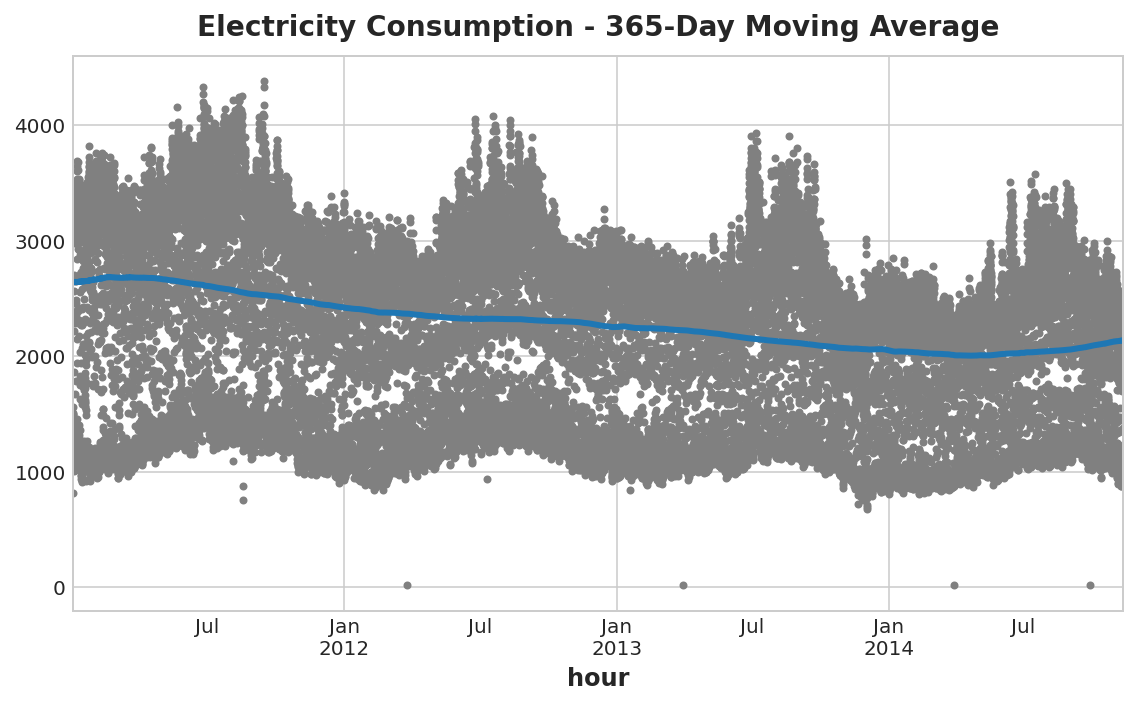

In [6]:
moving_average = df1.rolling(
    window=8760,       # one year window
    center=True,       # puts the average at the center of the window
    min_periods=4380,  # choose about half the window size
).mean()               # compute the mean (could also do median, std, min, max, ...)

ax = df1.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Electricity Consumption - 365-Day Moving Average", legend=False,
);

*As we can see in the plot above, there is an overall (slightly) decreasing trend, so the task in this notebook is to learn this trend and forecast the next 120 hours (5 days).*

In [7]:
dp = DeterministicProcess(
    index=df1.index,     # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# in_sample creates features for the dates given in the `index` argument
X = dp.in_sample()
y = df1.to_frame()[1]  # the target

# create and fit model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

# make out of sample predictions
X = dp.out_of_sample(steps=120)
date_index2 = pd.date_range('2014-11-12 02:00:00', periods=120, freq='H')
y_fore = pd.Series(model.predict(X), index=date_index2)

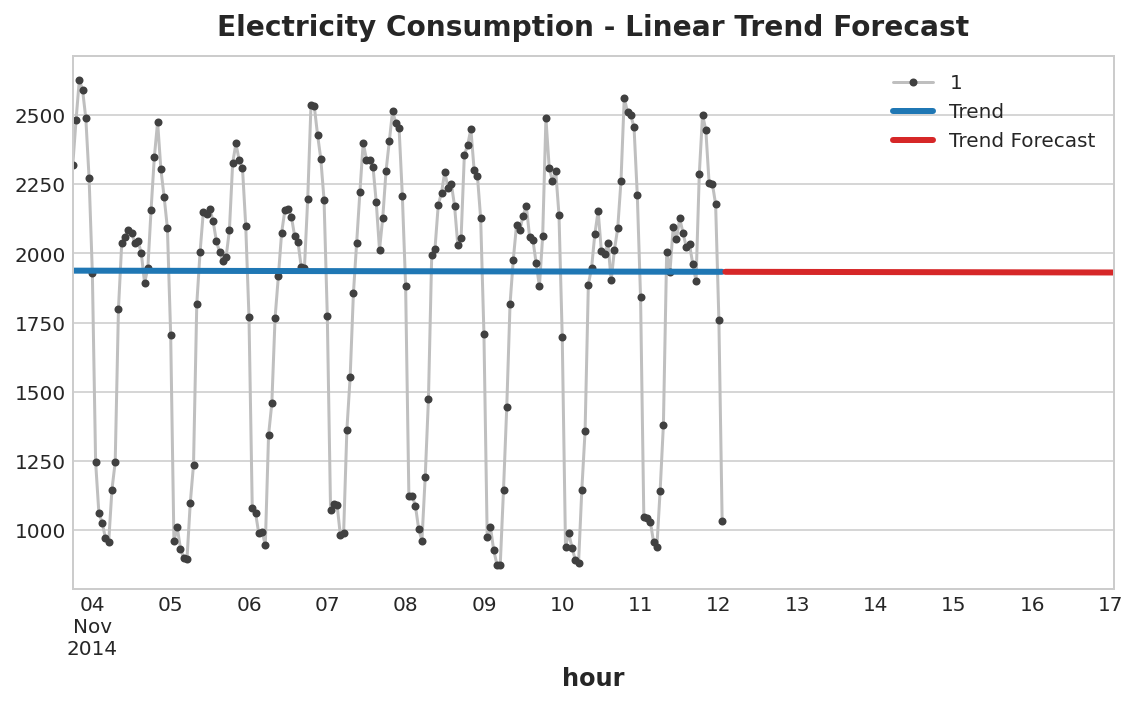

In [8]:
ax = df1.tail(200).plot(title="Electricity Consumption - Linear Trend Forecast", **plot_params)
ax = y_pred.tail(200).plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()
plt.savefig('trend.png')

#### * SEASONALITY <a name="SEASONALITY"></a>

The Seasonality is that regular periodic change in the series. Seasonality, when it exists, is usually a result of cycles of the natural world. We make some seasonal plots to see whether our series exhibits some seasonality behaviour.

In [9]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1H")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104, 208, 416])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "BiDaily (208)",
            "Daily (416)"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

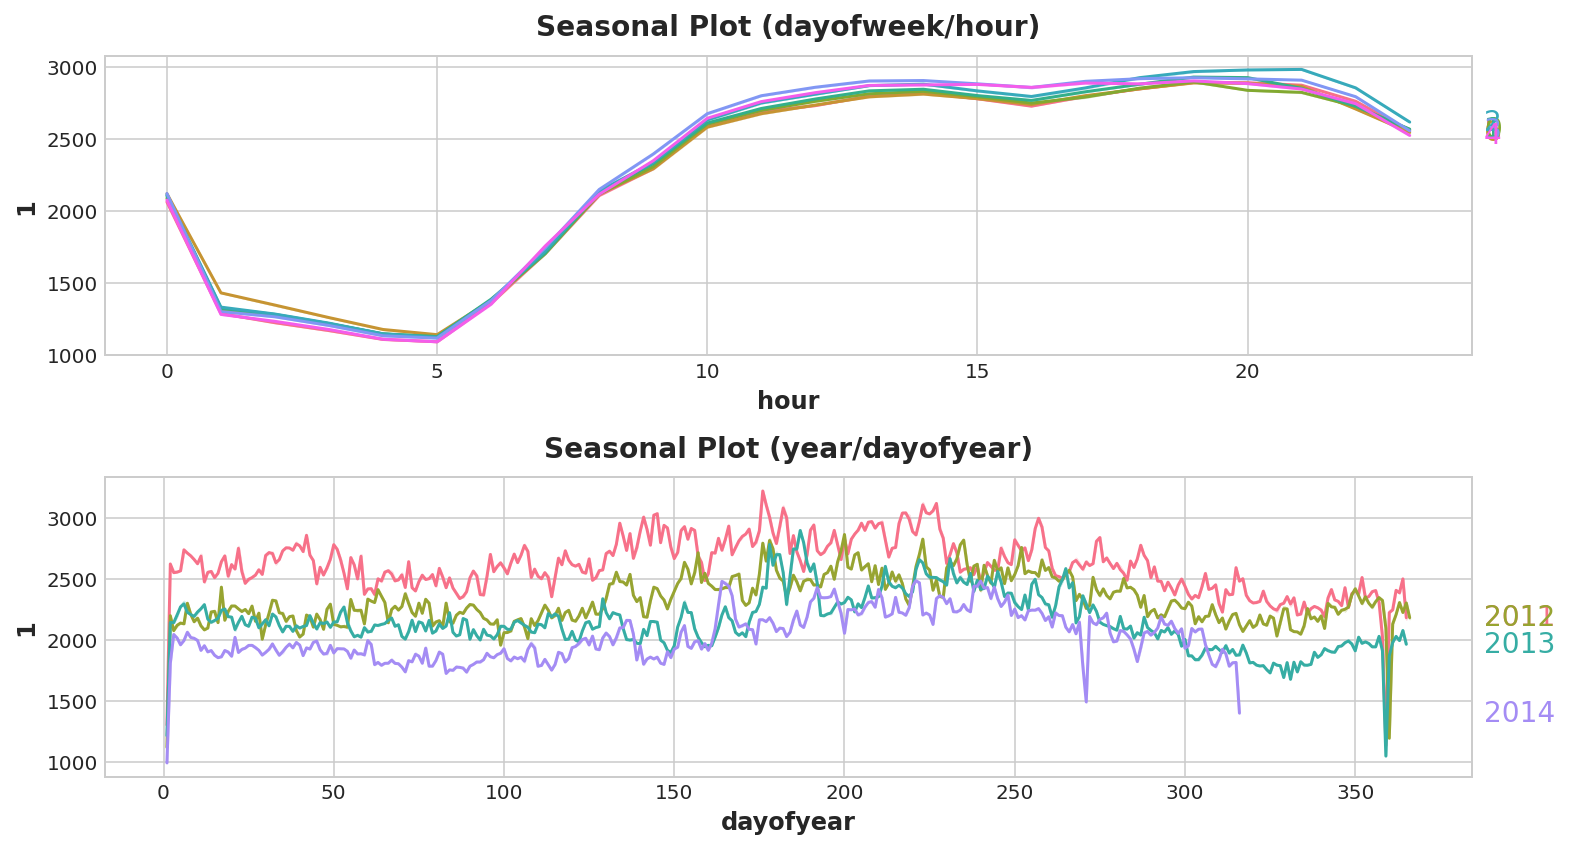

In [10]:
X = pd.DataFrame(df, columns=['hour', 1]).set_index('hour').copy()

# days within a week
X["hour"] = X.index.hour           # the x-axis (freq)
X["dayofweek"] = X.index.dayofweek     # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y=1, period="dayofweek", freq="hour", ax=ax0)
seasonal_plot(X, y=1, period="year", freq="dayofyear", ax=ax1);

In this plot what we can see is a strong daily seasonality, where consumption is low during the night (sleep time) and high during the day. As we said earlier, this is mainly due to the nature of the world. We can see some weak yearly seasonality as well, where there is a slight bump in day 200.

In the periodiagram below we can see this behaviour represented.

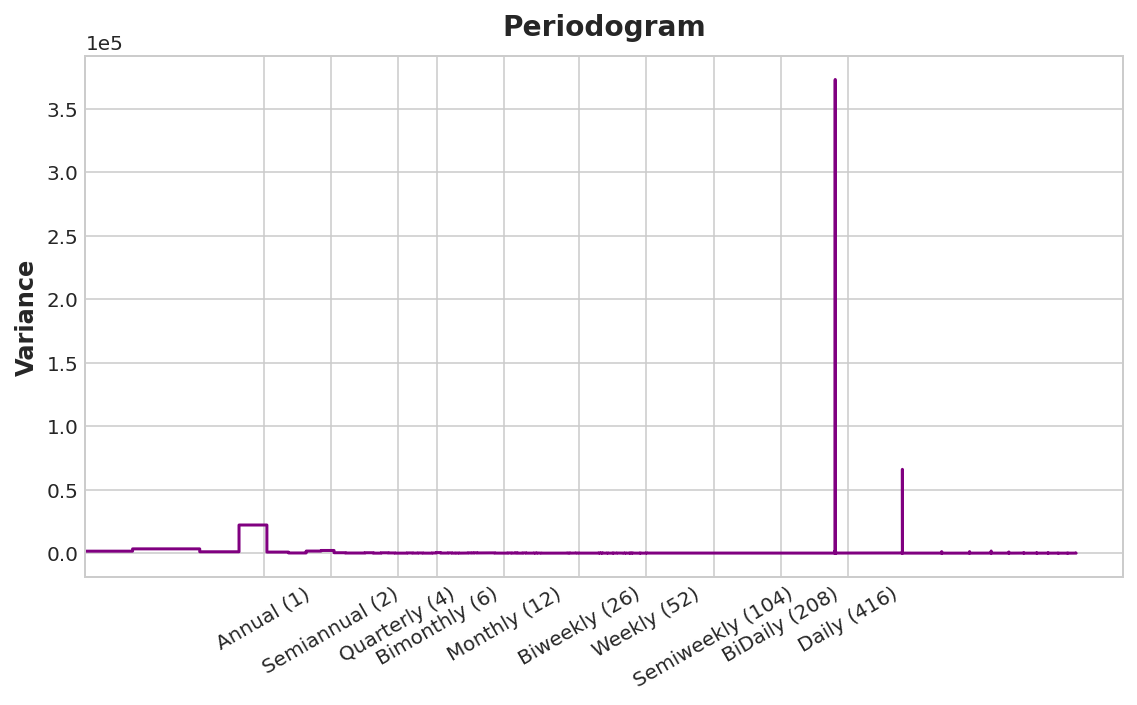

In [11]:
plot_periodogram(X[1]);

As it was commented previously, the ```periodiagram``` matches perfectly our analysis above. We can see that there is a weak anual seasonality and a strong daily seasonality. The ```periodiagram``` also sugests a sub-daily seasonality. With this said, we can use 1 Fourier pair to model the one year seasonality. As for the Daily periodicity, we use **seasonal indicators**, since they are better suited for small timestep observations (hourly in our case).

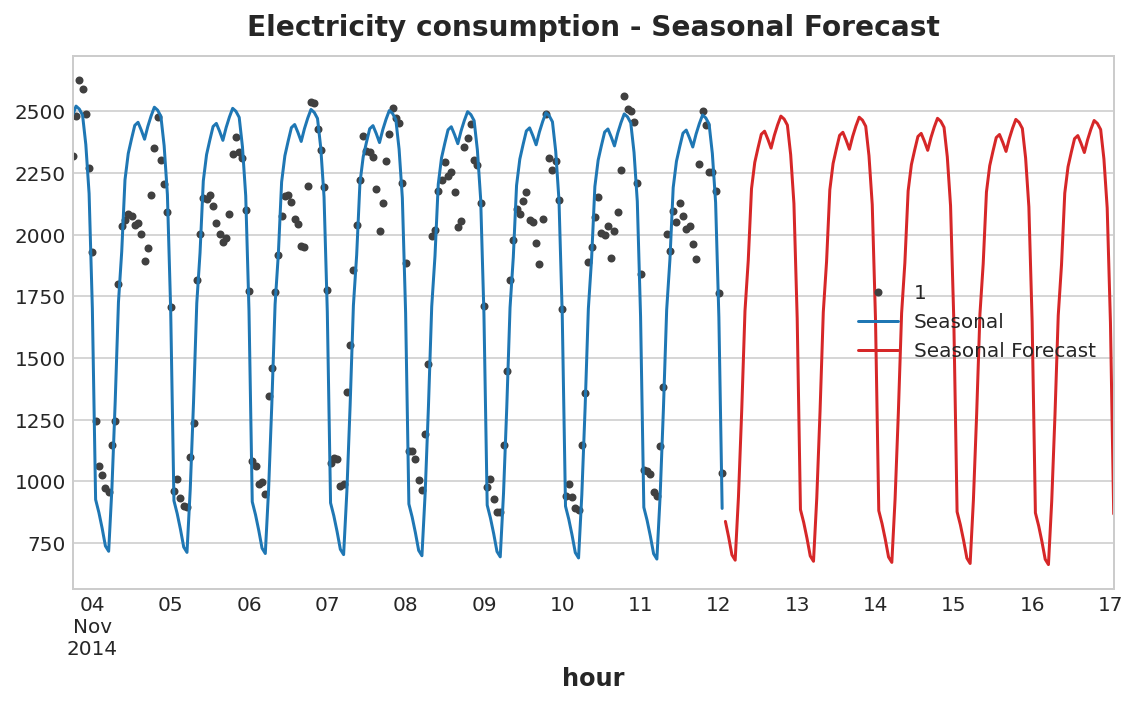

In [12]:
fourier = CalendarFourier(freq="A", order=1)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df1.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
y = pd.DataFrame(df, columns=['hour', 1]).set_index('hour')[1]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=y.index)

X_fore = dp.out_of_sample(steps=120)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.tail(200).plot(color='0.25', style='.', title="Electricity consumption - Seasonal Forecast")
ax = y_pred.tail(200).plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()
plt.savefig('seasonality.png')

#### * CYCLES <a name="CYCLES"></a>
What we have done so far is the time dependence of the series: ```Trend``` and ```Seasonality```. These are time features in the sense that we use the time index of the series as a feature to forecast. Another important type of dependence is the serial depence. This can be manifested in **cycles** where future values depend on previous ones. To make predictions in this case, we need ```Laged features```.

In [13]:
df1 = pd.DataFrame(df, columns=['hour', 1]).set_index('hour')

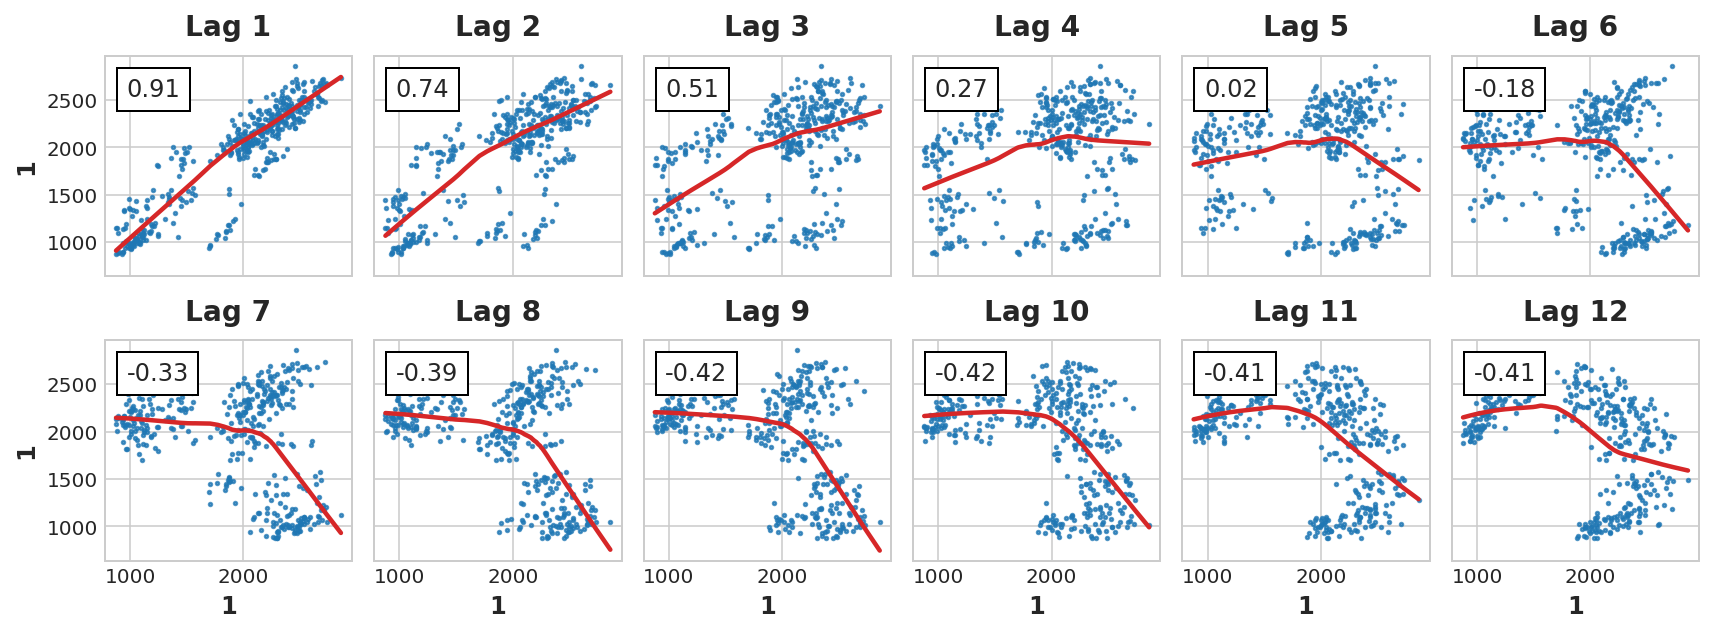

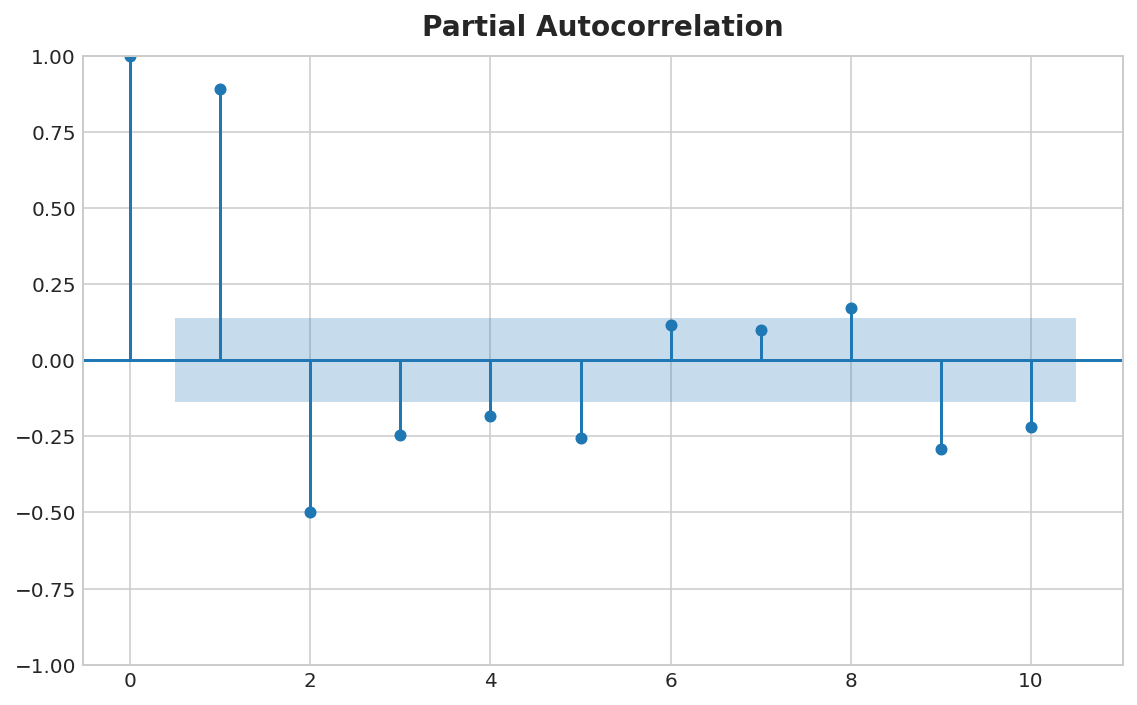

In [14]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

_ = plot_lags(df1[1].tail(400), lags=12, nrows=2)
_ = plot_pacf(df1.squeeze().tail(200), lags=10)

In the lag plot, it can be seen the relationship between the time serie and its lags. In order to have a better analysis of these data, we used **autocorrelation** as a measure, which allows us to observe in the second plot that there is a strong autocorrelation with lags 1 and 2 which is mostly linear. On the other hand, it can be seen that the rest of the lags have low score. The ```pacf``` plot matches with the lag plots.

In [15]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

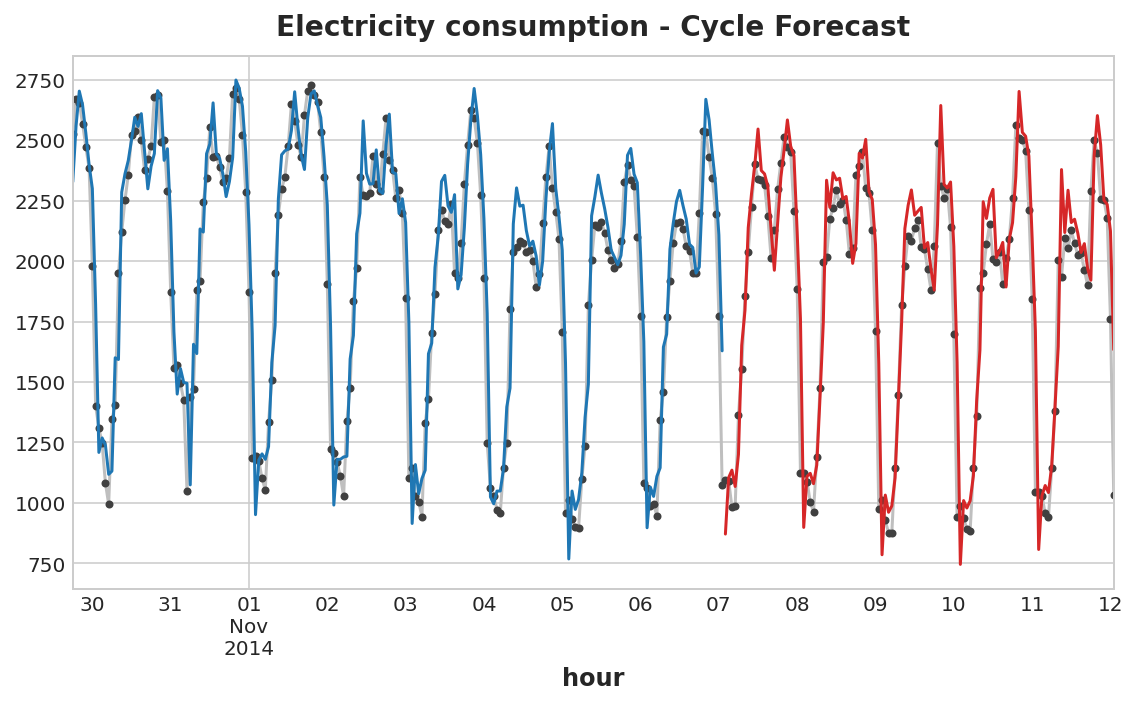

In [16]:
X = make_lags(df1[1], lags=6)
X = X.fillna(0.0)

# Create target series and data splits
y = df1[1].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=120, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_train.tail(200).plot(**plot_params, title="Electricity consumption - Cycle Forecast")
ax = y_test.plot(**plot_params)
ax = y_pred.tail(200).plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
plt.savefig('cycles.png')

# 2. TRAINING THE LSTM Neural Network <a name="Training"></a>

Once we understand the nature of the data, its behavior and the need to have a model that allows us to forecast the next steps given a series of previous data. We proceed to train a model based on the LSTM, where our first step is to clean and accommodate our data, and then proceed to apply our recurrent neural network in the LSTM subsection.

#### 1. LOADING & PREPARING TRAINING DATA <a name="sub21"></a>

In [17]:
INPUT_FOLDER = '../input/electricity-time-series-dataset-ml-winter-2022/'

df = pd.read_csv(os.path.join(INPUT_FOLDER, 'train.csv'))

In [18]:
# rectifying a typo in column name
df = df.rename({' "Sequence"': 'Sequence'}, axis=1)

# function to transform 
def convert(string):
    li = np.array([float(num) for num in list(string.split(" "))])
    return li

df['Sequence'] = df['Sequence'].apply(lambda x: (convert(x)))

#### 2. TRAINING THE MODEL <a name="sub22"></a>

In [19]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))               # scale function to treat data

index = 1440                                            # number of inputs to consider for each client
features = []
labels = []
    
for user in range(len(df['Sequence'])):                 # number of users: len(df['Sequence'])=250
    client = df['Sequence'][user].reshape(-1, 1)
    last = len(df['Sequence'][user])                    
    client_train = client[last-index:last]              # extracting just the last data points of each client
    client_train = sc.fit_transform(client_train)       

    for i in range(720, (len(client_train)-120)):
        features.append(client_train[i-720:(i-1), 0])   # set of all the features
        labels.append(client_train[i:(i+120), 0])       # set of all labels

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

#### 3. LSTM: Long Short-Term Memory network <a name="sub23"></a>

As mentioned above the recurrent neural network applied is the one based on the LSTM model, the optimizer is the **adam optimizer** and the loss is measured with the **Mean Squared Error Loss**.

In [20]:
import tensorflow as tf

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 25, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 25, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 25),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 120)
])

2022-04-30 09:51:14.401215: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
start = time.time()
history = model.fit(features, labels, epochs = 15, batch_size = 1500, verbose = 1)
end = time.time()

2022-04-30 09:51:16.178338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
100/100 [==============================] - 580s 6s/step - loss: 0.0967
Epoch 2/15
100/100 [==============================] - 575s 6s/step - loss: 0.0587
Epoch 3/15
100/100 [==============================] - 574s 6s/step - loss: 0.0417
Epoch 4/15
100/100 [==============================] - 574s 6s/step - loss: 0.0297
Epoch 5/15
100/100 [==============================] - 577s 6s/step - loss: 0.0272
Epoch 6/15
100/100 [==============================] - 553s 6s/step - loss: 0.0257
Epoch 7/15
100/100 [==============================] - 565s 6s/step - loss: 0.0246
Epoch 8/15
100/100 [==============================] - 569s 6s/step - loss: 0.0237
Epoch 9/15
100/100 [==============================] - 568s 6s/step - loss: 0.0231
Epoch 10/15
100/100 [==============================] - 570s 6s/step - loss: 0.0224
Epoch 11/15
100/100 [==============================] - 570s 6s/step - loss: 0.0218
Epoch 12/15
100/100 [==============================] - 573s 6s/step - loss: 0.0214
Epoch 13/15
1

# 3. TESTING DATA <a name="TESTING"></a>

Once our model is trained now we can try it on the test data set given and see the results in the submission part.

In [24]:
test_df = pd.read_csv(os.path.join(INPUT_FOLDER, 'test.csv'))
test_df['Sequence'] = test_df['Sequence'].apply(lambda x: (convert(x)))

In [25]:
predictions = []
index2 = 720                                                              # number of elements for each client
now = time.time()
for user_t in range(0,3700):                                              # number of predictions = 3700
    client = test_df['Sequence'][user_t].reshape(-1, 1)
    last = len(test_df['Sequence'][user_t])
    client_test = client[last-index2:last]                                # extraction of the last data points
    client_test = sc.fit_transform(client_test)
    X_test = []
    X_test.append(client_test)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_user = model.predict(X_test)
    predictions.append(sc.inverse_transform(np.array(pred_user).reshape(-1,1)))
    
print(time.time()-now)

441.5262930393219


# 4. RESULTS <a name="RESULTS"></a>

In [26]:
subs=np.array(predictions)
subs=subs[:,:,0]

# Creating the pandas DataFrame
df_subs = pd.DataFrame(subs)     #3700
df_subs.insert(0, "Id", range(251,3951))

df_subs = df_subs.rename({i: f'Prediction_{i+1}' for i in range(0,120)}, axis=1)

final_sub= df_subs
final_sub.to_csv("submissionA.csv", index= False)

df_subs

,Id,Prediction_1,Prediction_2,Prediction_3,Prediction_4,Prediction_5,Prediction_6,Prediction_7,Prediction_8,Prediction_9,...,Prediction_111,Prediction_112,Prediction_113,Prediction_114,Prediction_115,Prediction_116,Prediction_117,Prediction_118,Prediction_119,Prediction_120
0,251,10.862582,10.330717,10.018291,9.477564,8.824837,8.172043,7.499390,6.924379,6.323172,...,7.665036,8.362057,9.008750,9.397456,9.552973,10.269161,10.468647,10.322878,11.182178,10.847153
1,252,73.941521,74.378723,76.156990,79.402557,83.702187,87.883415,92.343849,95.764450,99.737022,...,105.242165,105.001541,103.722626,101.453949,98.212509,93.600876,88.213844,83.485252,78.598610,75.133621
2,253,6.565021,6.586755,6.528491,6.513972,6.498644,6.420773,6.476503,6.397000,6.469712,...,6.269749,6.351182,6.400234,6.390393,6.430070,6.453491,6.356336,6.363427,6.272558,6.252699
3,254,404.749481,351.565826,316.254700,297.097382,298.867218,321.253937,354.466125,397.566864,446.626129,...,632.745544,651.448914,664.066345,674.419250,672.887329,657.627502,631.439392,580.596130,534.588501,470.496735
4,255,222.583008,207.346863,192.747086,182.814575,177.638992,176.974854,183.176208,193.096695,207.209686,...,277.166443,286.380524,290.936096,293.601318,293.227142,288.916992,279.972260,268.525940,252.134155,235.317963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,3946,45.706837,42.099674,40.049198,37.060177,33.404736,31.021318,25.954128,23.085314,21.307432,...,40.406712,45.648983,49.784088,51.965408,52.536385,52.671143,51.764553,47.910156,46.798923,43.532455
3696,3947,2254.318359,2222.764404,2160.824463,2106.287109,2048.453857,1979.466187,1944.381592,1898.524170,1894.836670,...,2071.007568,2136.657471,2191.468994,2218.604248,2248.200928,2268.844238,2245.958252,2247.600098,2212.649414,2187.619385
3697,3948,378.502808,381.027527,373.420441,367.253326,366.237274,362.820831,356.912384,350.751953,347.563171,...,395.940369,410.640289,431.967224,440.213562,444.125153,443.597107,431.319305,412.106934,421.496033,405.356262
3698,3949,2765.021973,2769.820557,2782.549072,2806.356201,2850.802979,2884.956055,2934.816650,2981.771484,3027.618896,...,3157.489502,3152.239014,3137.575684,3105.303955,3064.455566,2998.417480,2933.844971,2881.605957,2827.777588,2786.855957


#### EXAMPLES <a name="results1"></a>

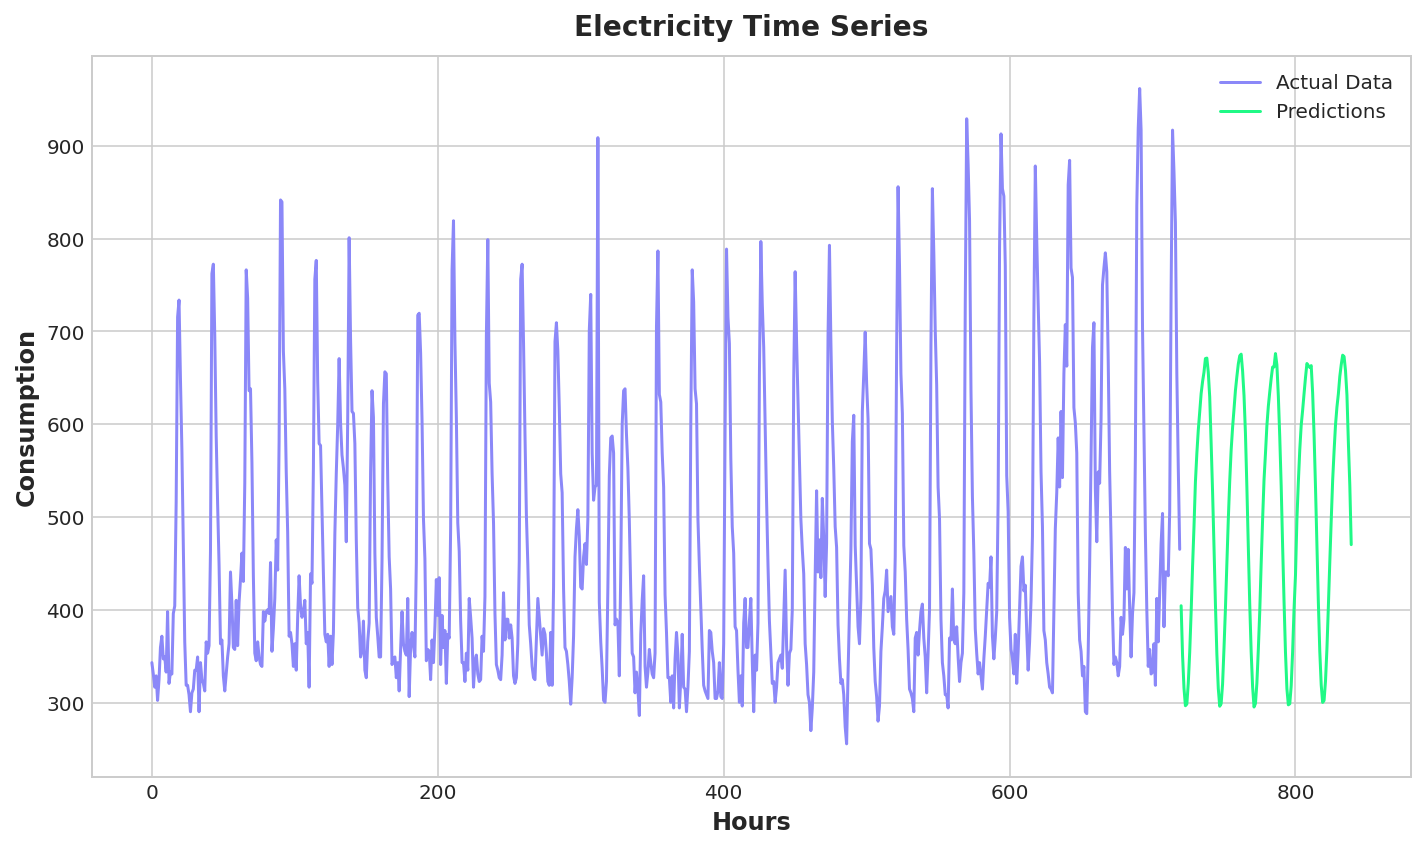

In [27]:
u=3                                          #user number 3

client = test_df['Sequence'][u].reshape(-1, 1)
last=len(client)
real_data = client[last-720:last]            
   #print(real_data.shape)
predicted_data = predictions[u].reshape((120,))
   #print("predicted_data", predicted_data.shape)
x= np.array([i for i in range(720,840)])
   #print ("x", x.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))  
plt.plot(real_data, color='xkcd:lavender blue', label='Actual Data')  

plt.plot(x, predicted_data, color='xkcd:wintergreen', label='Predictions')  
plt.title('Electricity Time Series')  
plt.xlabel('Hours')  
plt.ylabel('Consumption')  
plt.legend()  

plt.savefig('u3.png')
plt.savefig('u3.pdf')
plt.show() 

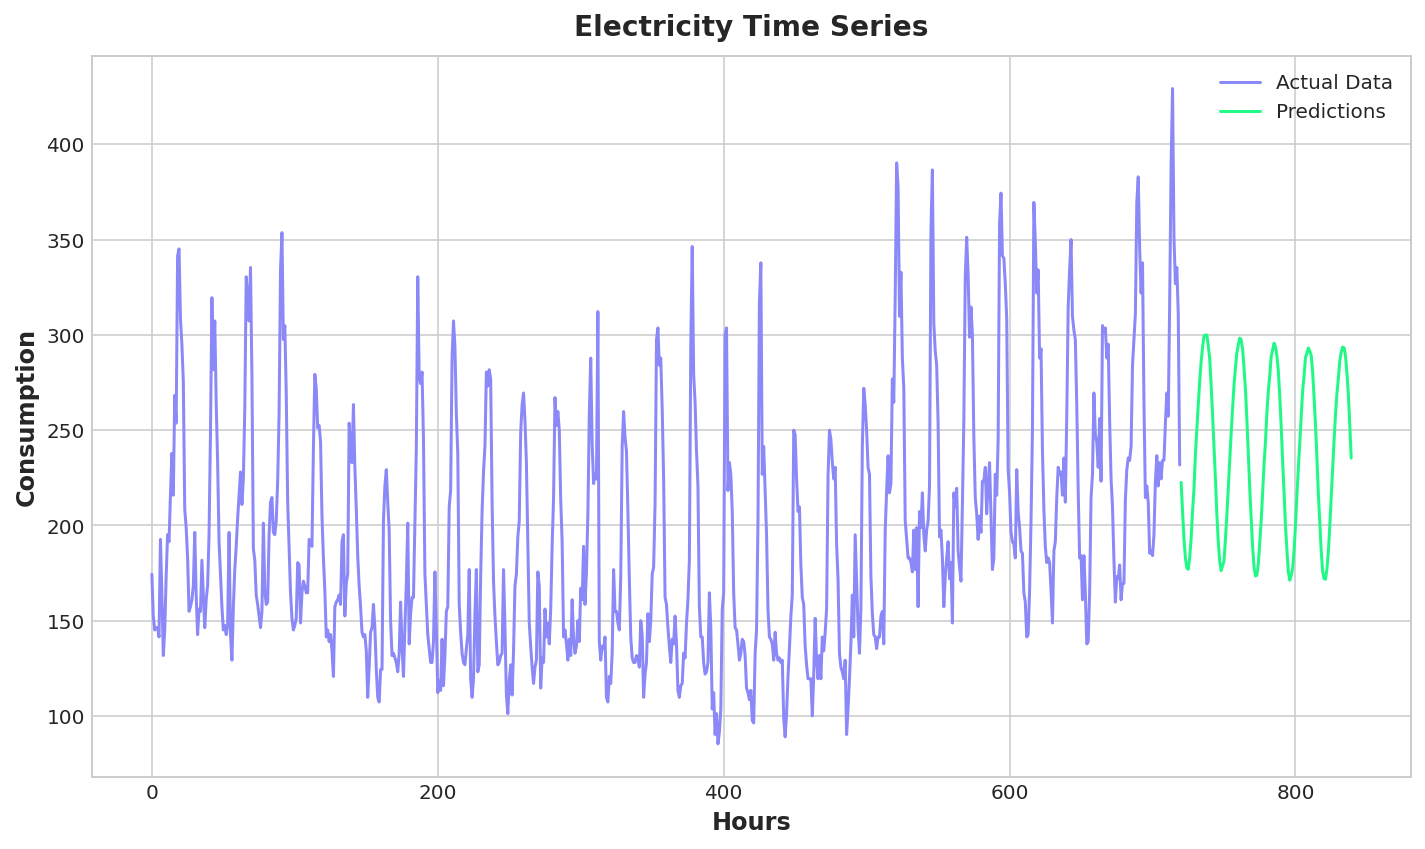

In [28]:
u=4                                          #user number 4

client = test_df['Sequence'][u].reshape(-1, 1)
last=len(client)
real_data = client[last-720:last]            
predicted_data = predictions[u].reshape((120,))
x= np.array([i for i in range(720,840)])

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))  
plt.plot(real_data, color='xkcd:lavender blue', label='Actual Data')  

plt.plot(x, predicted_data, color='xkcd:wintergreen', label='Predictions')  
plt.title('Electricity Time Series')  
plt.xlabel('Hours')  
plt.ylabel('Consumption')  
plt.legend()  

plt.savefig('u4.png')
plt.savefig('u4.pdf')
plt.show() 

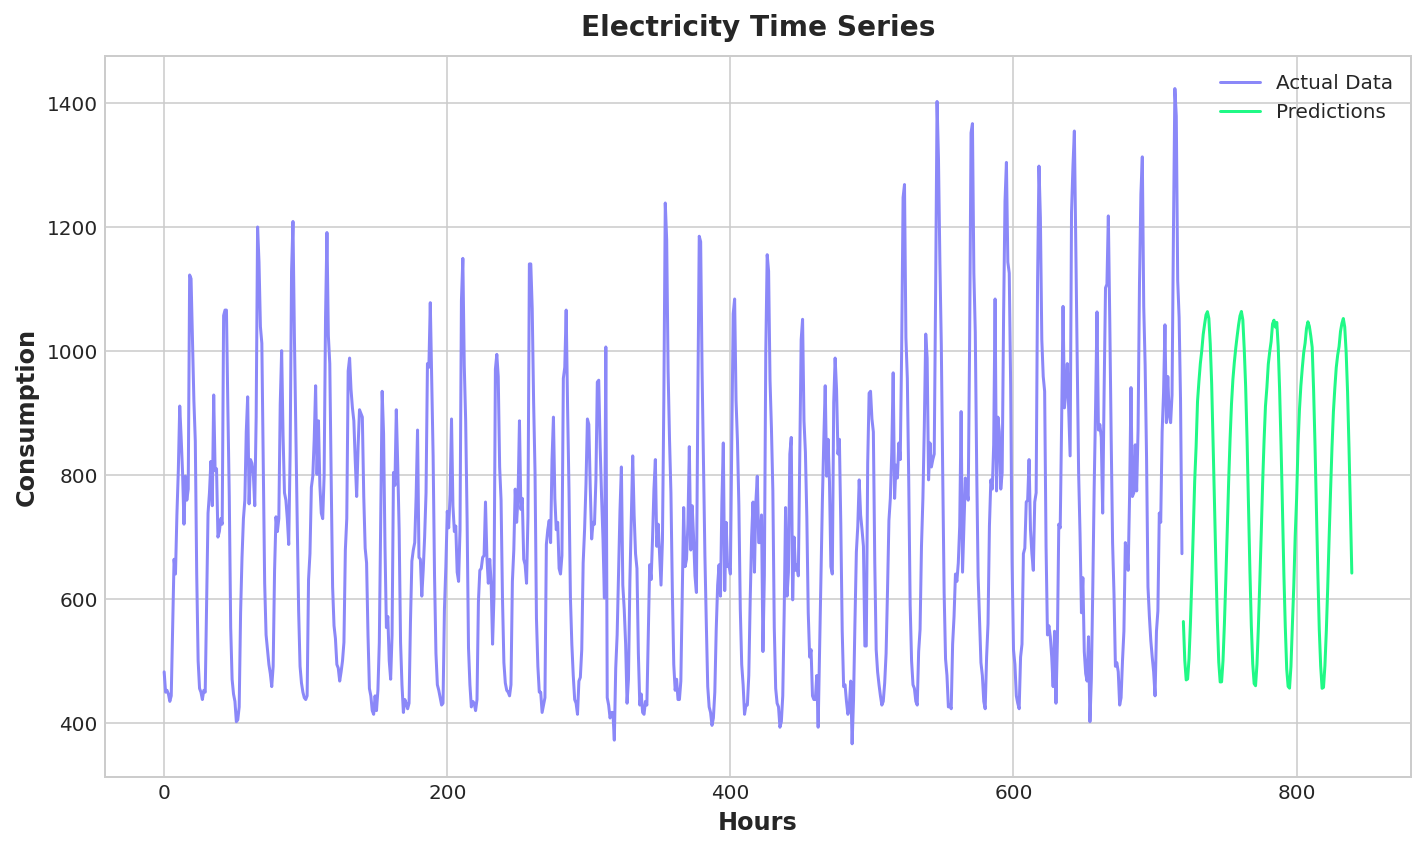

In [29]:
u=5                                          #user number 5

client = test_df['Sequence'][u].reshape(-1, 1)
last=len(client)
real_data = client[last-720:last]            
predicted_data = predictions[u].reshape((120,))
x= np.array([i for i in range(720,840)])

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))  
plt.plot(real_data, color='xkcd:lavender blue', label='Actual Data')  

plt.plot(x, predicted_data, color='xkcd:wintergreen', label='Predictions')  
plt.title('Electricity Time Series')  
plt.xlabel('Hours')  
plt.ylabel('Consumption')  
plt.legend()  

plt.savefig('u5.png')
plt.savefig('u5.pdf')
plt.show() 

# **END OF CODE**